In [1]:
###########################################################################
# Xception(CIFAR10、CIFAR-10)
###########################################################################

#==============================================================
# 0.インポート/定数定義
#==============================================================
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import GlobalAveragePooling2D
from keras.layers import  Dropout

from keras.optimizers import Adam

from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

from keras.datasets import cifar10
from keras.utils import np_utils

import os
import numpy as np
import matplotlib.pyplot as plt
#from scipy.misc import toimage
from PIL.Image import fromarray as toimage

from keras.applications.xception import Xception

import copy


#### 定数
BATCH_SIZE_VAL = 50

#EPOCHS_VAL = 10
EPOCHS_VAL = 5

XCEP_WEIGHT='xception_weights.h5'

CLASS_NUM = 10

Using TensorFlow backend.


In [0]:
# /////////////////////////////////////////////////////////////
# 1.前処理
# /////////////////////////////////////////////////////////////

In [0]:
#==============================================================
# 1-1.画像のダウンロード
#==============================================================
# CIFAR-10 の画像をロードする
# 普通はネットからダウンロードしてきてそれを読み込むのだが、
# KerasではCIFAR10をダウンロードしてきて読み込むところまでを
# やってくれる機能があるのでそれを使っている
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

##X_train= [[[[ 59  62  63]
##   [ 43  46  45]
##   [ 50  48  43]
##   ...
##   [158 132 108]
##   [152 125 102]
##   [148 124 103]]
##
##  [[ 16  20  20]
##   [  0   0   0]
##   [ 18   8   0]
##   ...
##   [123  88  55]
##   [119  83  50]
##   [122  87  57]]
##   ・・・
##
##y_train= [[6]
## [9]
## [9]
## ...
## [9]
## [1]
## [1]]
##
##X_test= [[[[158 112  49]
##   [159 111  47]
##   [165 116  51]
##   ...
##   [137  95  36]
##   [126  91  36]
##   [116  85  33]]
##
##y_test= [[3]
## [8]
## [8]
## ...
## [5]
## [1]
## [7]]

# CIFAR-10の教師データは 0 ～ 9 までの数字になっているが、これだと人はわかりにくいので
# 0 → airplane, 1 → automobile…のような対応関係を配列で持っておく
cifar10_labels = np.array([
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'])

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


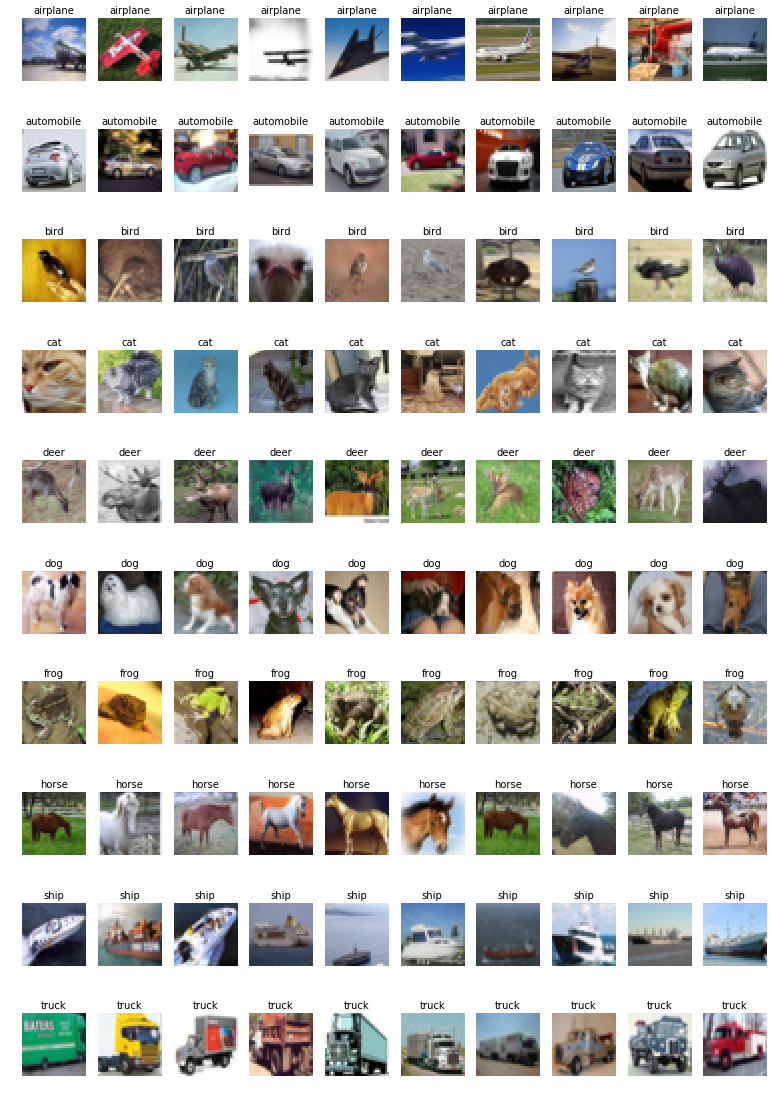

In [4]:
#==============================================
## 1-2.事前のデータ確認
#==============================================

import numpy as np
import matplotlib.pyplot as plt
#from scipy.misc import toimage


print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


nclasses = 10
pos = 1
# w16,h24のエリアに描画する。
plt.figure(figsize=(16,24), dpi=60)

# matplotlib で学習用画像を10個ずつ表示する
# matplotlib はグラフを表示するためのライブラリでものすごく多機能なため、
# 便利ではあるがかなりとっつきづらい
# 細かい説明はキリがないので興味があれば調べてみてほしい。
# クラス毎にループを回す
for targetClass in range(nclasses):
    targetIdx = []
    for i in range(len(y_train)):
        if y_train[i][0] == targetClass:
            # 対応するクラスのy_trainのインデックスを保持する
            targetIdx.append(i)

    # 配列をランダムに並べ変える
    np.random.shuffle(targetIdx)
    # クラス内の先頭10個だけ選んで表示
    for idx in targetIdx[:10]:
        # X_train[idx] は3次元の行列になっており、そのままだと数字の羅列が表示されるだけなので
        # toimage を使って画像に変換してから表示する
        img = toimage(X_train[idx])
        # 縦10×横10ファイル数を表示
        plt.subplot(10, 10, pos)
        plt.imshow(img)
        plt.axis('off')
        # タイトルにラベルを表示
        plt.title(cifar10_labels[y_train[idx][0]])
        pos += 1

plt.show()

In [0]:
#==============================================
## 1-3.データ変換
#==============================================

# floatに変換しておく
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# 正規化
X_train /= 255.0
X_test /= 255.0

# one-hot vector に変換したほうが都合が良い
# たとえば 4 ではなくて [0, 0, 0, 0, 1, 0, 0, 0, 0, 0] のようなデータにする
# ##ラベルに距離の属性を持たせなくて済む！！！
# こうしないとクラス分類ではなくて回帰として扱われてしまいうまくいかない
n_classes = 10
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)

##【one-hot vectorとは】
##ダミー変数に変換すること！！！
##val      val_a   val_b   val_c
##----  → ------  ------  ------
##a          1       0       0
##b          0       1       0
##c          0       0       1

##X_train =  [[[[0.23137255 0.24313726 0.24705882]
##   [0.16862746 0.18039216 0.1764706 ]
##   [0.19607843 0.1882353  0.16862746]
##   ...
##   [0.7019608  0.69411767 0.6784314 ]
##   [0.6431373  0.6431373  0.63529414]
##   [0.6392157  0.6392157  0.6313726 ]]]]
##  
##X_test =  [[[[0.61960787 0.4392157  0.19215687]
##   [0.62352943 0.43529412 0.18431373]
##   [0.64705884 0.45490196 0.2       ]
##   ...
##   [0.4509804  0.45490196 0.36862746]
##   [0.25882354 0.25490198 0.23137255]
##   [0.10588235 0.10588235 0.10588235]]
##  
##       INDEX:0～0
##Y_train =  [[0. 0. 0. ... 0. 0. 0.]
## [0. 0. 0. ... 0. 0. 1.]
## [0. 0. 0. ... 0. 0. 1.]
## ...
## [0. 0. 0. ... 0. 0. 1.]
## [0. 1. 0. ... 0. 0. 0.]
## [0. 1. 0. ... 0. 0. 0.]]
##  
##      INDEX:0～0
##Y_test =  [[0. 0. 0. ... 0. 0. 0.]
## [0. 0. 0. ... 0. 1. 0.]
## [0. 0. 0. ... 0. 1. 0.]
## ...
## [0. 0. 0. ... 0. 0. 0.]
## [0. 1. 0. ... 0. 0. 0.]
## [0. 0. 0. ... 1. 0. 0.]]



In [0]:
# /////////////////////////////////////////////////////////////
# 2.Xception
# /////////////////////////////////////////////////////////////

In [7]:
#==============================================
## 2-1.Xceptionのモデルを構築する。
#==============================================
def create_xception():
  # 入力テンソルを定義しておく
  # 画像のサイズ(h,w,チャネル数(RGBで3))
  inputs = Input(shape=(32, 32, 3))

  # Xception-10クラス分類。
  model = Xception(weights=None, include_top=True, input_tensor=inputs, classes=CLASS_NUM)
  
  # 重み全部上書きする
  for layer in model.layers: 
      layer.trainable = True

  # モデルコンパイル。コスト関数：categorical_crossentropy(交差エントロピー誤差) , metricsは 正解率
  model.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy', metrics=["accuracy"])

  return model


#### モデル構築
model = create_xception()
print("+++ model.summary() +++")
model.summary()


W0624 13:46:23.387970 140573569755008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0624 13:46:23.405586 140573569755008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0624 13:46:23.408652 140573569755008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0624 13:46:23.432558 140573569755008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0624 13:46:23.433572 1405735697

+++ model.summary() +++
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 15, 15, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 15, 15, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 15, 15, 32)   0           block1_conv1_bn[0][0]            
_____________________________________________________________________________________

In [8]:
#==============================================
## 2-2.学習
#==============================================

# 学習の関数
def fitFunc(inputModel, X_train_data, Y_train_data,  filePrefix ,wSaveFlg):
  # 1 epoch ごとに　weights.01.hdf5, weights.02.hdf5 … のようにモデルを保存してくれる
  # ★学習の途中でmodelを保存する。コールバック関数。epoch1回終わるごとにモデルが保存される。
  #   ここではepochのファイル名にしている。
  ###  コールバック関数  ###
  callback_cp = ModelCheckpoint(filepath=filePrefix + '_weights.{epoch:02d}.hdf5')

  # 1 epoch ごとに val_acc　に変化があるか調べて、殆ど変わってなかったら学習を打ち切る
  # ★過学習したときにモデルを止める！！validationのaccuracyがpatience:2回まで我慢する。
  #   mode は上がる下がると良いのかをします。autoだと自動で判断する。
  #   verbose=1でプリントしてくれる。
  #   val_acc:バリデーションデータセットの精度
  callback_es = EarlyStopping(monitor='val_acc', patience=2, mode='auto', verbose=1)

  # ジェネレータ【重要】
  # batch_sizeを指定してメモリーリークを防ぐ
  #   バッチサイズとは 1 回に計算するデータの数のこと。
  #   バッチサイズを小さくする、たとえば 100 個とかにすると、
  #   1 回の計算で 100 個しか扱わない。
  #   この計算 1 まとまりのことをエポックと呼んでいる。
  #   またデータ数よりもバッチサイズがかなり小さい場合はミニバッチ（学習）と呼ぶ。
  #   バッチサイズを小さくすることで、使用するメモリ量が少なくなる。
  #   また 1 エポックあたりのパラメータ更新回数が増えるので、収束も速くなる。
  #   ただし、バッチサイズを小さくしすぎるとパラメータが暴れてしまうという欠点がある。
  #   したがって、バッチサイズはいい感じに選ぶ必要がある。
  #   ちなみにバッチサイズを指定しないときは、全データの数になる。

  # epochs:整数で，モデルを訓練するエポック数． エポックは，提供されるxおよびyデータ全体の反復です．

  # 学習する
  # validation_split:validationの割合
  his = inputModel.fit(X_train_data, Y_train_data,
                batch_size=BATCH_SIZE_VAL,
                epochs=EPOCHS_VAL,
                validation_split=0.2,
                callbacks=[callback_cp, callback_es])

  if wSaveFlg:
    # 学習した重みを保存
    inputModel.save_weights(XCEP_WEIGHT)
  
  return his


### 学習実行
history = fitFunc(model, X_train, Y_train, 'model1', True)


W0624 13:46:28.336229 140573569755008 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 40000 samples, validate on 10000 samples
Epoch 1/5
40000/40000 [==============================] - 67s 2ms/step - loss: 1.4345 - acc: 0.4769 - val_loss: 2.0939 - val_acc: 0.3862
Epoch 2/5
40000/40000 [==============================] - 54s 1ms/step - loss: 1.0534 - acc: 0.6299 - val_loss: 1.4983 - val_acc: 0.5391
Epoch 3/5
40000/40000 [==============================] - 54s 1ms/step - loss: 0.8416 - acc: 0.7072 - val_loss: 1.3104 - val_acc: 0.6078
Epoch 4/5
40000/40000 [==============================] - 54s 1ms/step - loss: 0.7001 - acc: 0.7558 - val_loss: 1.1439 - val_acc: 0.6652
Epoch 5/5
40000/40000 [==============================] - 54s 1ms/step - loss: 0.5834 - acc: 0.7959 - val_loss: 1.0907 - val_acc: 0.6546


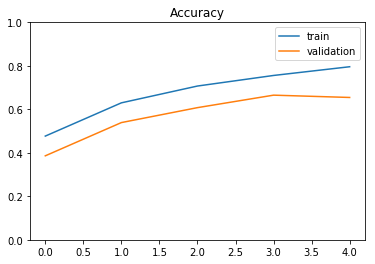

In [9]:
#==============================================
## 2-3.精度の描画
#==============================================
import numpy as np
import matplotlib.pyplot as plt

# 描画の関数
def plotFunc(inHis):
  epoch = np.arange(len(inHis.history['acc']))
  # <class 'numpy.ndarray'>
  # epoch = [0 1 2 3 4 5]

  # accuracy と validation accuracy の推移をプロットする
  plt.title('Accuracy')
  # y軸の範囲0.0～1.0
  plt.ylim(0.0, 1.0)

  #・inHis.history:
  #  {'val_loss': [1.648613947033882, ・・・],
  #   'val_acc': [0.4728000000119209, ・・・],
  #   'loss': [1.3863265740126371, ・・・],
  #   'acc': [0.5063250005198643, ・・・]}
  #・inHis:
  #  <keras.callbacks.History object at 0x7f94127f68d0>

  # x軸：epoch数、y軸:inHis.history['acc'],凡例:train
  plt.plot(epoch, inHis.history['acc'], label='train')

  # x軸：epoch数、y軸:inHis.history['val_acc'],凡例:validation
  plt.plot(epoch, inHis.history['val_acc'], label='validation')

  # 凡例をグラフ上に出す
  plt.legend()
  plt.show()
  
### 描画実行
plotFunc(history)


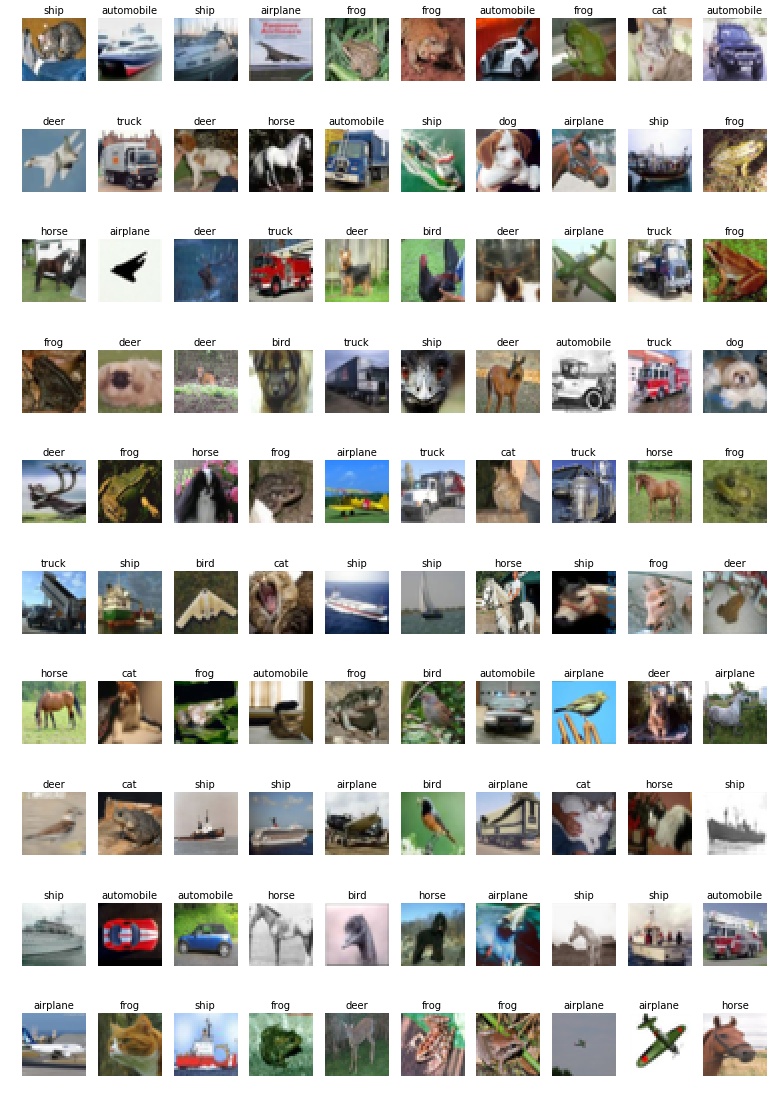

In [10]:
#==============================================
## 2-4.作ったモデルで実行
#==============================================

results = model.predict(X_test)
##<class 'numpy.ndarray'>
##(10000, 10)
##[[9.3436189e-02 4.3639988e-03 1.2936866e-03 ... 3.6223274e-02
##  3.3119796e-03 3.1835388e-04]
## [6.4462284e-03 1.4985842e-04 2.2184736e-06 ... 2.4948406e-09
##  9.9338913e-01 1.2444694e-05]
## [5.8614958e-02 9.3148870e-04 1.7577963e-03 ... 7.5326279e-05
##  9.2667145e-01 1.1901227e-02]
## ...
## [1.4164560e-06 3.3334450e-06 2.0431653e-01 ... 7.9179788e-03
##  1.7957157e-04 2.1580227e-05]
## [6.8654412e-01 2.5796095e-01 3.7540432e-02 ... 1.4178273e-05
##  1.9961278e-04 7.5550493e-06]
## [8.2166589e-06 1.0961240e-06 3.4247626e-06 ... 9.8534459e-01
##  4.4454353e-07 2.3437798e-07]]


# 実行結果の描画の関数
def predResultPlotFunc(predRes, inputX):
  # 計算用に退避
  inX = inputX.copy()
  
  # 正規化解除
  inX *= 255.0

  # intに変換しておく
  inX = inX.astype('uint8')


  pos = 1
  # w16,h24のエリアに描画する。
  plt.figure(figsize=(16,24), dpi=60)

  # 100個描画するループ
  for i in range(100):
    # 3次元の数値の行列を画像に変換
    # inX[i]は正規化(つまり0～1)されている。
    # 正規化されていても画像は表示できる。
    img = toimage(inX[i])

    # 値が最大の配列のindexを取得
    label = predRes[i].argmax()
    # 縦10×横10ファイル数を表示
    plt.subplot(10, 10, pos)
    plt.imshow(img)
    plt.axis('off')
    # ラベル文字列をタイトルとして表示
    plt.title(cifar10_labels[label])
    pos += 1        

  # 定性分析するため、実際に表示してみる
  # 効率よくやるには正解/不正解を出す。
  plt.show()

  
#### 実行結果の描画実行
predResultPlotFunc(results, X_test)